# Decision Tree Modeling

In this report, I developed a decision tree model as part of Task 6. The model uses decision trees to classify our study participants* according to their cyber status (cybersensitive, cyberaware, mainstream, low mainstream, and null) based on the survey and interview data. The goal of the model is to classify/predict what cyber status of an individual. 

I develop a conventional decision tree model and synthesize several decision trees through random forests. 

*Because we found the cyber status of the individuals we interviewed, I focused on this group, although I used both the survey results for these individuals in addition to the coding and observational data based on the interviews. 

## Part 1: Pre-Development

### Section 1.1: Data Cleaning
Feel free to skip this part. I gather all the data from our surveys and interviews of our participants 

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from scipy import signal

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Loading the datasets from their respective files
filepath = 'C:\\Users\\swphi\\Documents\\Indicia\\Epic\\Task 4\\'
file1 = pd.ExcelFile(filepath + 'Master EPIC dataset - copy.xlsx')
file2 = pd.ExcelFile(filepath + 'all survey responses - copy.xlsx')

cyber_status = file1.parse('Cyber Status')
psych_codes = file1.parse('Psych')
energy_codes = file1.parse('Energy')
device_codes = file1.parse('Device')
surveys = file2.parse('Interview Responses')
key = file2.parse('Question Key')

In [3]:
# Merging all the datasets into one data for the model
data = cyber_status.merge(psych_codes, left_on = 'Name', right_index = True)
data = cyber_status.merge(energy_codes, left_on = 'Name', right_index = True)
data = cyber_status.merge(device_codes, left_on = 'Name', right_index = True)
data = cyber_status.merge(surveys, left_on = 'Name', right_on = 'Name')

In [4]:
# Converting non-numerical data into numbers so that it will run through the decision tree packages

# Converts it to a quanitative variable based on the given key
def quantize(x, key):
    for k in key: 
        if x == key[k]:
            return k
    return x

'''
Key for Variable Edits: 
rent_or_own_quant: 0 if the user rents and 1 if the user owns
gender_quant: 0 if female and 1 if male
age_quant: Goes to smallest age in the range
household_income_quant: Goes to the smallest income and -1 if prefer not to answer
community_quant: 0 if rural, 1 if suburban, 2 if urban 
instructions_quant: 0 if wait for someone else, 1 if use instructions, 2 if figure out on your own
region_quant: 0 if southern california, 1 if northern california
smartphone_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
nonsmartphone_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
gaming_console_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
laptop_usage_quant:0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
ipod_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
fitness_tracker_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
health_fitness_app_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
home_automation_system_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
home_security_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
energyConsumption_app_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
money_management_app_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
tablet_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
music_app_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
gaming_app_usage_quant: 0 if never, 1 if a few times a month, 2 if a few times a week, 3 if once a day
data_plan_type_quant: 0 if they do not have a plan, 1 if 1-5 GB plan, 2 if more than 5 GB, 3 if unliminited, -1 if unsure what plan they have 
energy_awareness_quant: 0 if not aware, 1 if generally aware, 2 if always aware
social_adoption_quant: 0 if one of the last to adopy any new technology, 1 if wait until somewhat widely adopted, 2 if one of the first ones to adopt 
'''

quant_keys = {'Rent or Own': ['rent_or_own_quant', 'Do you currently rent or own your primary residence?', {0: 'Rent', 1: 'Own'}],
              'Gender': ['gender_quant', 'Please indicate your gender below:', {0: 'Female', 1: 'Male'}],
              'Age': ['age_quant', 'Please indicate your age below:', {25: '25-34', 35: '35-44', 45: '45-54', 55: '55-64', 65: '65-74'}],
              'Household Income': ['household_income_quant', 'Which of the following ranges best indicates your annual household income?', {2000: '$20,000 to $49,999', 50000: '$50,000 to $99,999', 100000: '$100,000 to $149,999', 150000: '$150,000 to $199,999', 200000: '$200,000 or more', -1: 'Prefer not to answer'}],
              'Community': ['community_quant', 'How would you describe the type of community you reside in?', {0: 'Rural community', 1: 'Suburban community', 2: 'City or Urban community'}],
              'Instructions': ['instructions_quant', 'Which of the following statements best describes you?', {0: 'When I get a new device, I usually wait for someone else to help me figure out how to use it', 1: 'When I get a new device, I jump right into the instructions and learn how to use it in detail', 2: 'When I get a new device, I figure out how to use it on my own, and look at the instructions only if I get stuck'}], 
              'Region': ['region_quant', 'Region', {0: 'Southern California', 1: 'Northern California'}],
              'Smartphone Usage': ['smartphone_usage_quant', 'Mobile phone with internet capability:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Non-Smartphone Usage': ['nonsmartphone_usage_quant', 'Mobile phone without internet capability:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Gaming Console Usage': ['gaming_console_usage_quant', 'Gaming console (such as Playstation, X-box, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Laptop Usage': ['laptop_usage_quant', 'Laptop:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'ipod usage': ['ipod_usage_quant', 'Portable digital music player (such as iPod, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Fitness Tracker Usage': ['fitness_tracker_usage_quant', 'Health / fitness tracker (such as Fitbit, Garmin watch, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Health/Fitness App Usage': ['health_fitness_app_usage_quant', 'Health / fitness tracking apps on your mobile phone (such as RunKeeper, Strava, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Home Automation System Usage': ['home_automation_system_usage_quant', '', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}], 
              'Home Security Usage': ['home_security_usage_quant', 'Home security or home monitoring system (such as ADT, web-enabled surveillance devices, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Energy Consumption App Usage': ['energy_consumption_app_usage_quant', 'MEnergy consumption tracking devices, apps or services:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Money Management App Usage': ['money_management_app_usage_quant', 'Money management applications (such as Mint, Quicken, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}], 
              'Tablet Usage': ['tablet_usage_quant', 'Tablet (such as iPad, etc.):How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}], 
              'Music App Usage': ['music_app_usage_quant', 'Music apps on my phone:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}],
              'Gaming App Usage': ['gaming_app_usage_quant', 'Gaming apps on my phone:How often, if ever, do you use or access the following?', {0: 'Never', 1: 'A few times a month or less', 2: 'A few times a week', 3: 'At least once a day'}], 
              'Data Plan Type': ['data_plan_type_quant', 'What type of the data plan do you have on your mobile phone?', {-1: 'I have a data plan, but not sure about the type', 0: 'I do not have a data plan', 1: '1-5 GB per month', 2: 'More than 5 GB per month', 3: 'Unlimited data plan'}],
              'Energy Awareness': ['energy_awareness_quant', 'Consider the level of energy consumption in your household. Which of the following statements would you agree with the most?', {0: 'I am not aware of the level of energy consumption in my household. I generally do not participate in making changes around the house to reduce our energy consumption.', 1: 'I am generally aware of some aspects of energy consumption in my household. I do not monitor all aspects of energy usage in great detail, but participate in making changes to our energy consumption whenever it is convenient.', 2: 'I am fully aware of, and monitor the level of energy consumption in my household. I have made and continue to make many changes wherever possible to our energy usage, and lead the charge in this aspect in my household.'}],
              'Social Adoption': ['social_adoption_quant', 'Which of the following statements best describes you?', {0: 'I am usually the last one to adopt any new technology', 1: 'I wait for new technologies to be somewhat widely adopted before adopting them myself', 2: 'I am usually among the first ones to buy the latest electronic devices'}]
              }

for q in quant_keys:
    current = quant_keys[q]
    data[current[0]] = data[q].apply(quantize, args = (current[2],))
    data[current[0]] = data[current[0]].fillna(0)
    key = key.append(pd.Series(current, index = key.columns), ignore_index = True)


In [5]:
# Develops the X and y matrices for model development

dep_vars = ['region_quant', 'Smartphone', 'Non-Smartphone', 'Gaming Console ', 
            'Laptop', 'iPod', 'Fitness Tracker',
           'Home Automation System', 'Health/Fitness App', 'Home Securtiy',
           'Energy Consumption App', 'Money Management App', 'Tablet ',
           'Music Apps', 'Gaming Apps ', 'smartphone_usage_quant',
           'nonsmartphone_usage_quant', 'gaming_console_usage_quant', 'laptop_usage_quant',
           'ipod_usage_quant', 'fitness_tracker_usage_quant', 'home_automation_system_usage_quant',
           'health_fitness_app_usage_quant', 'home_security_usage_quant',
           'energy_consumption_app_usage_quant', 'money_management_app_usage_quant',
           'tablet_usage_quant', 'music_app_usage_quant', 'gaming_app_usage_quant', 'data_plan_type_quant',
           'Relieved', 'Happy', 'Anxious', 'Unaffected', 'Concerned',
           'Bored', 'Free', 'Excited', 'Crippled', 'Stressed', 'Unproductive', 'Frustrated', 
           'Disconnected', 'Adoption', 'Breadth', 'Explore',
           'Advice', 'Bills', 'Energy Saving', 'Fun', 'Easy', 'Technology News',
           'social_adoption_quant', 'instructions_quant', 'gender_quant', 'age_quant',
           'household_income_quant', 'Household', 'Minors', 'community_quant', 'rent_or_own_quant']

X = data[dep_vars]
y_qual = data['Cyber Status']

cyber_key = {0: 'Null', 1: 'Low Mainstream', 2: 'Mainstream', 3: 'Cyberaware', 4: 'Cybersensitive'}
y = y_qual.apply(quantize, args = (cyber_key,))
y_quant = y


### Section 1.2 Resampling

In this section, we use bootstrap resampling to create a larger version of the sample data with a size of 300. Decision tree models vary impulsively on smaller datasets, and this will help address this. Resampling allows one to create a distribution, which is larger (or sometimes smaller) than the orginal, but which still represents the overall distribution. 

In [6]:
X_resample = signal.resample(X, 300)
X_resample = pd.DataFrame(X_resample, columns = X.columns)
X_resample = X_resample.round()
y_resample = signal.resample(y_quant, 300)
y_resample = y_resample.round()
y_resample = pd.DataFrame(y_resample, columns = ['Cyber Status'])

In [7]:
# Develops a qualtiative version the y_resample for models that require a qualitative version
def qualitize(x, key, minimum, maximum): 
    if x < minimum: 
        return key[minimum]
    if x > maximum:
        return key[maximum]
    return key[x]

y_resample_qual = pd.DataFrame(columns = ['Cyber Status'])
y_resample_qual['Cyber Status'] = y_resample['Cyber Status'].apply(qualitize, args = (cyber_key, 0, 4,))


I then tested the means and standard deviations of each column to ensure that the resample is still representative of the original data. 

They are pretty much the same with only slight varaition several decimal places in (the one exception to this is income, which because it contains 5 to 6 digit values means that its slight variation is proportionally larger. It is still a slight variation). This indicates that the resampling still matches the sample's distribution.  

In [8]:
test = pd.DataFrame(columns = ['Original Mean', 'Resampled Mean', 'Original Std', 'Resampled Std'])
test['Original Mean'] = X.mean()
test['Resampled Mean'] = X_resample.mean()
test['Original Std'] = X.std()
test['Resampled Std'] = X_resample.std()
test['Mean Difference'] = abs(test['Original Mean'] - test['Resampled Mean'])
test['Std Difference'] = abs(test['Original Std'] - test['Resampled Std'])
display(test)

,Original Mean,Resampled Mean,Original Std,Resampled Std,Mean Difference,Std Difference
region_quant,0.454545,0.443333,0.505650,0.497609,0.011212,0.008041
Smartphone,0.939394,0.926667,0.242306,0.261118,0.012727,0.018813
Non-Smartphone,0.060606,0.066667,0.242306,0.249861,0.006061,0.007555
Gaming Console,0.303030,0.326667,0.466694,0.497440,0.023636,0.030747
Laptop,0.909091,0.890000,0.291937,0.313413,0.019091,0.021475
iPod,0.484848,0.483333,0.507519,0.532919,0.001515,0.025399
Fitness Tracker,0.181818,0.193333,0.391675,0.395572,0.011515,0.003897
Home Automation System,0.121212,0.150000,0.331434,0.357668,0.028788,0.026234
Health/Fitness App,0.393939,0.400000,0.496198,0.510754,0.006061,0.014556
Home Securtiy,0.121212,0.136667,0.331434,0.362990,0.015455,0.031556


Here are the comparisons of Cyber Status variables. They are also basically the same. 

In [9]:
comparison = pd.DataFrame({'Group': ['Original', 'Resampled'], 'Mean of Cyber Status': [y_quant.mean(), y_resample['Cyber Status'].mean()], 'Standard Deviation of Cyber Status': [y_quant.std(), y_resample['Cyber Status'].std()] })
comparison

,Group,Mean of Cyber Status,Standard Deviation of Cyber Status
0,Original,1.939394,1.273268
1,Resampled,1.923333,1.279157


## Part 2: Decision Tree Development

### Step 1: 

We will first determine the most accurate decision tree model to construct. In particular, we will determine the best type of splitting function - gini index or entropy - and what are maximum depth is. Below are the accuracies when conducting Leave-One-Out Cross-Validation (LOOCV) for each type of function type for each depth. 

Two conclusions from the table:

1) Gini index are consistently more accurate than entropy.

2) The accuracies start to level off at a maximum depth of 7, inicating that 7 is the best maximum depth

Thus we will use the gini index with a maximum depth of 7. 

In [10]:
loocv = model_selection.LeaveOneOut()
accuracy = pd.DataFrame( columns = ['Maximum Depth', 'Gini Index Accuracy', 'Entropy Accuracy'])

for depth in range(1, 34):
    score = [depth]
    
    clf_gini = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=depth, min_samples_leaf=1)
    results = model_selection.cross_val_score(clf_gini, X_resample, y_resample_qual, cv=loocv)
    score.append(results.mean())
    
    clf_entropy = tree.DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=depth, min_samples_leaf=1)
    results = model_selection.cross_val_score(clf_entropy, X_resample, y_resample_qual, cv=loocv)
    score.append(results.mean())
    
    accuracy.loc[len(accuracy)] = score

accuracy

,Maximum Depth,Gini Index Accuracy,Entropy Accuracy
0,1.0,0.253333,0.333333
1,2.0,0.313333,0.353333
2,3.0,0.336667,0.436667
3,4.0,0.453333,0.476667
4,5.0,0.626667,0.570000
5,6.0,0.686667,0.596667
6,7.0,0.696667,0.666667
7,8.0,0.760000,0.720000
8,9.0,0.753333,0.726667
9,10.0,0.743333,0.740000


In [11]:
accuracy.to_csv('Decision Tree LOOCV Results v2.csv')

### Step 3: Build initial decision tree.

Here is the primary decision tree. I uses the gini index function and has a maximum depth of 8. It's LOOCV accuracy score is 76%. 

In [12]:
max_depth = 8
dtree = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=max_depth, min_samples_leaf=1)
dtree.fit(X_resample, y_resample)
tree.export_graphviz(dtree, out_file='tree.dot', feature_names=X.columns, filled=True, rounded=True )

In [13]:
results = model_selection.cross_val_score(dtree, X_resample, y_resample_qual, cv=loocv)
print('LOOCV Accuracy Score: ' + str(100*results.mean()) + '%.')

LOOCV Accuracy Score: 76.0%.


# Part 3: Random Forests

## Step 1: Build the model.

Here I build a random forest with the resampled set. I then tested it on both the resampled set and original sample. For both, it has an accuracy of 100%. (Accuracy is measured by the percentage of individuals the model is able to accurately predict.)

In [14]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_resample, y_resample)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
pred = rf.predict(X_resample)
correct = 0
for x in range(len(X_resample)):
    if pred[x] == y_resample['Cyber Status'][x]:
        correct += 1
score = correct/len(X_resample)
print('Accuracy on resampled set: ' + str(100*score) +'%')

Accuracy on resampled set: 100.0%


In [16]:
pred = rf.predict(X)
correct = 0
for x in range(len(X)):
    if pred[x] == y[x]:
        correct += 1
score = correct/len(X)
print('Accuracy on original sample: ' + str(100*score) +'%')

Accuracy on original sample: 100.0%


## Step 2: Plot the model.

The graph below shows the 10 most important variables, which have been most significant variables when trying to classify each individual among all the trees. A larger, full table with the relative significance of all the variables is provided below that. (I made it latter table for your records; it is too much information for a final report, especially since most of it is extraneous. The grap provides the most important variables to discuss.)  

Text(0.5,0,'Relative Importance')

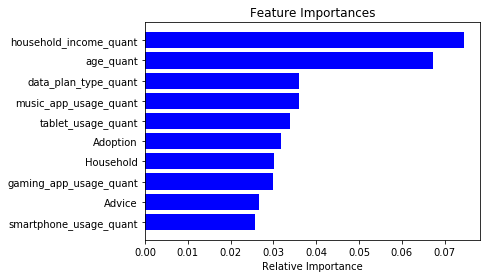

In [17]:
# The code for this graphing approach is based on a similar model from from http://www.agcross.com/2015/02/random-forests-scikit-learn/ 
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
l = len(indices)
top_indices = indices[l-10:l]
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(top_indices)), importances[top_indices], color='b', align='center')
plt.yticks(range(len(top_indices)), features[top_indices])
plt.xlabel('Relative Importance')

In [18]:
def column_name(column_number, df):
    return df.columns[column_number]

def get_importance(index, list_of_importances):
    return list_of_importances[index]

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

importances_ranking = pd.DataFrame({'Column Number': indices})
#output.Predicted = output.Predicted.apply(qualitize, args = (cyber_key, 0, 4,))
# 'Column Name': column_name(X, indices), 'Relative Importance': importances})
importances_ranking['Column Name'] = importances_ranking['Column Number'].apply(column_name, args = (X,))
importances_ranking['Relative Importance'] = importances_ranking['Column Number'].apply(get_importance, args = (importances,))
print_full(importances_ranking.sort_values('Relative Importance', ascending = False))

    Column Number                         Column Name  Relative Importance
60             56              household_income_quant             0.074478
59             55                           age_quant             0.067227
58             29                data_plan_type_quant             0.036077
57             27               music_app_usage_quant             0.036042
56             26                  tablet_usage_quant             0.033839
55             43                            Adoption             0.031879
54             57                           Household             0.030134
53             28              gaming_app_usage_quant             0.029813
52             46                              Advice             0.026732
51             15              smartphone_usage_quant             0.025634
50             18                  laptop_usage_quant             0.024239
49             44                             Breadth             0.023527
48             58        

# Part 4 Energy Saving Estimator

Below is a preliminary estimator for how much energy cybersensitives and cyberawares save compared with the other groups in the population based on the above decision tree/random forest model. We used the proportions of each group predicted by the model with the estimates for average energy usage for each group in our study from Task 5 to predict energy savings. 

This is a preliminary estimate. Testing the model against a larger sample population would help verify and/or refine the figure. We intend to do this by testing our model against technology consumption and energy usage data of Prince Williams County, VA provided by Network Dynamics Simulation Science Laboratory at Virginia Tech. 

In [19]:
print('Break down by Cyber Status according to Our Model:')
pred = rf.predict(X)
output = pd.DataFrame({'Actual': y_qual, 'Predicted': pred})
output.Predicted = output.Predicted.apply(qualitize, args = (cyber_key, 0, 4,))
output.Predicted.value_counts()

Break down by Cyber Status according to Our Model:


Mainstream        11
Low Mainstream     9
Cybersensitive     6
Null               4
Cyberaware         3
Name: Predicted, dtype: int64

In the model, cybersensitives make-up about 18.18% of the pouplation. 

Based on estimates in Task 5, we will approximate cybers serviced in PG&E as using 465 kWh of energy per month as opposed to 562 kWh for non-cybers, a difference 97 kWh per month per cybersensitive, or 1,164 per year. Using the estimate of 18.18%, if one multiplies 211.636 (0.1818x1164) to the size of poulation in question, then one can estimate the amount of energy saved by Cybersensitives in a specific PG&E population. PG&E possesses 5.2 million people, which would that we would estimate that cybers in PG&E use 1,100,509,091 kWh less energy per year than non-cybers in PG&E. 

Similarly, in Task 5, we found that in SCE, cybers use on average 135 kWh less of energy per month or 1,620 kWh per year than non-cybers (648 and 783 kWh per month for cybers and non-cybers respectively) if one multiplies 294.545 (0.1818x1620) to the size of poulation in question, then one can estimate the amount of energy saved by Cybersensitives in that population. PG&E possesses 14 million people, which would that we would estimate that cybers in SCE use 4,123,636,364 kWh less energy per year than non-cybers in SCE. 

In total, we would estimate that cybers use 5,224,145,455 kWh less energy than non-cybers per year in both regions combined. 

In [7]:
# Uses 18/99 in place of 0.1818% for a more accurate result
5200000*1164*18/99 + 14000000* 1620 * 18/99

5224145454.545454

In [2]:
14000000* 1620 * 18/99

4123636363.6363635

In [1]:
5200000*1164*18/99

1100509090.909091